In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression


# ***IMPORT DATAS***

In [ ]:
url = "https://drive.google.com/file/d/1t3Rxpb5Hr0baI1KZWSvrAujv68A_CdnK/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

In [ ]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# ***SPLIT DATAS***

In [ ]:
# X and y creation
X = data.copy()
X.pop('Id')
y = X.pop("SalePrice")
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ***PREPROCESSING***

In [ ]:
# 1. defining categorical & ordinal columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(SimpleImputer())

# 3. categorical pipeline
    # # 3.1 defining ordinal & onehot columns

ordinal_col_names = ['ExterQual', 
                     'ExterCond', 
                     'BsmtQual', 
                     'BsmtCond', 
                     'BsmtExposure',
                     'BsmtFinType1', 
                     'KitchenQual', 
                     'FireplaceQu', 
                     'LotShape',
                     'BsmtFinType2', 
                     'HeatingQC', 
                     'GarageFinish', 
                     'GarageQual', 
                     'GarageCond',
                     'PoolQC', 
                     'Fence']

ordinal_cols = X_cat.columns.get_indexer(ordinal_col_names)
ohe_cols = X_cat.columns.get_indexer(list(set(X_cat) - set(ordinal_col_names)))

X_cat_ordinal = X_cat.columns[ordinal_cols]
X_cat_ohe = X_cat.columns[ohe_cols]

    ## 3.2 explicitly determine categories for ordinal encoding including "N_A"
ExterQual_cats = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cats = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_cats = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
LotShape_cats = ["N_A",'Reg', 'IR1', 'IR2', 'IR3']
BsmtFinType2_cats = ['N_A','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
HeatingQC_cats = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_cats = ['N_A','Unf','RFn','Fin']
GarageQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
PoolQC_cats = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
Fence_cats = ["N_A",'NA','MnWw','GdWo','MnPrv','GdPrv']

cats_ord = [ExterQual_cats, ExterCond_cats, BsmtQual_cats, BsmtCond_cats, 
            BsmtExposure_cats, BsmtFinType1_cats, KitchenQual_cats, FireplaceQu_cats, 
            LotShape_cats,BsmtFinType2_cats,HeatingQC_cats,GarageFinish_cats,GarageQual_cats,
            GarageCond_cats,PoolQC_cats,Fence_cats]

        ### 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=cats_ord), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
    ]
)

    ## 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder
                                )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)


# ***MODELING***

In [ ]:
scaler = StandardScaler()
scores = pd.DataFrame()

In [ ]:
scores

""


##***Ridge***

In [ ]:
from sklearn.linear_model import Ridge


Ridge_pipeline = make_pipeline(full_preprocessing, 
                             scaler,
                             Ridge())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "ridge__alpha": range(1,30,3)
}

Ridge_search = RandomizedSearchCV(Ridge_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

Ridge_search.fit(X_train, y_train)

scores.loc['Ridge', 'MAE'] = Ridge_search.best_score_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [ ]:
Ridge_predictions = Ridge_search.predict(X_test)
scores.loc['Ridge', 'RMSE'] = mean_squared_error(y_true = y_test, y_pred = Ridge_predictions, squared=False)
scores.loc['Ridge', 'MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Ridge_predictions)
scores.loc['Ridge', 'R2'] = r2_score(y_true = y_test, y_pred = Ridge_predictions)

##***NearestNeighbors***

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


KNR_pipeline = make_pipeline(full_preprocessing, 
                             scaler,
                             KNeighborsRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "kneighborsregressor__n_neighbors": range(1,1000,50)

}

KNR_search = RandomizedSearchCV(KNR_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

KNR_search.fit(X_train, y_train)

scores.loc['KNregression', 'MAE'] = KNR_search.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
KNR_predictions = KNR_search.predict(X_test)
scores.loc['KNregression', 'RMSE'] = mean_squared_error(y_true = y_test, y_pred = KNR_predictions, squared=False)
scores.loc['KNregression', 'MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = KNR_predictions)
scores.loc['KNregression', 'R2'] = r2_score(y_true = y_test, y_pred = KNR_predictions)

##***PoissonRegressor***


In [ ]:
from sklearn import linear_model

Poisson_pipeline = make_pipeline(full_preprocessing, 
                             scaler,
                              linear_model.PoissonRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "poissonregressor__max_iter": range(100,1000,50),
    "poissonregressor__alpha": range(1,30)

}

Poisson_search = RandomizedSearchCV(Poisson_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100
                      )

Poisson_search.fit(X_train, y_train)

scores.loc['PoissonRegression', 'MAE'] = Poisson_search.best_score_

In [ ]:
Poisson_predictions = Poisson_search.predict(X_test)
scores.loc['PoissonRegression', 'RMSE'] = mean_squared_error(y_true = y_test, y_pred = Poisson_predictions, squared=False)
scores.loc['PoissonRegression', 'MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Poisson_predictions)
scores.loc['PoissonRegression', 'R2'] = r2_score(y_true = y_test, y_pred = Poisson_predictions)

##***LinearRegression***

In [ ]:
from sklearn.linear_model import LinearRegression

LinearRegression_pipeline = make_pipeline(full_preprocessing, 
                             scaler,
                              LinearRegression())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False]
}

LinearRegression_search = RandomizedSearchCV(LinearRegression_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

LinearRegression_search.fit(X_train, y_train)

scores.loc['LinearRegression', 'MAE'] = LinearRegression_search.best_score_

In [ ]:
LinearRegression_predictions = LinearRegression_search.predict(X_test)
scores.loc['LinearRegression', 'RMSE'] = mean_squared_error(y_true = y_test, y_pred = LinearRegression_predictions, squared=False)
scores.loc['LinearRegression', 'MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = LinearRegression_predictions)
scores.loc['LinearRegression', 'R2'] = r2_score(y_true = y_test, y_pred = LinearRegression_predictions)

##***DecisionTree***

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DT_pipeline = make_pipeline(full_preprocessing, 
                             scaler,
                              DecisionTreeRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "decisiontreeregressor__max_depth": range(3,15,3),
    "decisiontreeregressor__min_samples_split" : range(50,200,30)
}

DT_search = RandomizedSearchCV(DT_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

DT_search.fit(X_train, y_train)

scores.loc['DecisionTree', 'MAE'] = DT_search.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
DT_predictions = DT_search.predict(X_test)

scores.loc['DecisionTree', 'RMSE'] = mean_squared_error(y_true = y_test, y_pred = DT_predictions, squared=False)
scores.loc['DecisionTree', 'MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = DT_predictions)
scores.loc['DecisionTree', 'R2'] = r2_score(y_true = y_test, y_pred = DT_predictions)

In [ ]:
scores



,MAE,RMSE,MAPE,R2
Ridge,-18786.329960,31619.319057,0.111044,0.869656
KNregression,-29707.041934,51421.277106,0.192614,0.655276
PoissonRegression,-16717.722597,22212.994935,0.089934,0.935672
LinearRegression,-20035.855347,30780.481600,0.118705,0.876480
DecisionTree,-25886.107693,42273.246656,0.148238,0.767021


#***Check Features***

## ***Variance***


In [ ]:
Scores_2 = []

In [ ]:
variance = VarianceThreshold(threshold=0)

###***Ridge***

In [ ]:
from sklearn.linear_model import Ridge


Ridge_pipeline_var = make_pipeline(full_preprocessing, 
                             scaler,
                             variance,
                             Ridge())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "ridge__alpha": range(1,30,3)
}

Ridge_search_var = RandomizedSearchCV(Ridge_pipeline_var,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

Ridge_search_var.fit(X_train, y_train)

# create a dictionary to keep track of the scores of different models 
scores.loc['Ridge', 'MAE_var'] = Ridge_search_var.best_score_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [ ]:
Ridge_predictions_var = Ridge_search_var.predict(X_test)
scores.loc['Ridge', 'RMSE_var'] = mean_squared_error(y_true = y_test, y_pred = Ridge_predictions_var, squared=False)
scores.loc['Ridge', 'MAPE_var'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Ridge_predictions_var)
scores.loc['Ridge', 'R2_var'] = r2_score(y_true = y_test, y_pred = Ridge_predictions_var)

###***NearestNeighbors***

In [ ]:
KNR_pipeline_var = make_pipeline(full_preprocessing, 
                             scaler,
                             variance,
                             KNeighborsRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "kneighborsregressor__n_neighbors": range(1,1000,50),

}

KNR_search_var = RandomizedSearchCV(KNR_pipeline_var,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

KNR_search_var.fit(X_train, y_train)

scores.loc['KNregression', 'MAE_var'] = DT_search.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
KNR_predictions_var = KNR_search_var.predict(X_test)

scores.loc['KNregression', 'RMSE_var'] = mean_squared_error(y_true = y_test, y_pred = KNR_predictions_var, squared=False)
scores.loc['KNregression', 'MAPE_var'] = mean_absolute_percentage_error(y_true = y_test, y_pred = KNR_predictions_var)
scores.loc['KNregression', 'R2_var'] = r2_score(y_true = y_test, y_pred = KNR_predictions_var)

###***PoissonRegressor***

In [ ]:
Poisson_pipeline_Var = make_pipeline(full_preprocessing,
                                     scaler, 
                                     variance,
                                     linear_model.PoissonRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "poissonregressor__max_iter": range(10,1000,10),
    "poissonregressor__alpha": range(1,30,3)

}

Poisson_search_var = RandomizedSearchCV(Poisson_pipeline_Var,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100
                      )

Poisson_search_var.fit(X_train, y_train)

scores.loc['PoissonRegression', 'MAE_var'] = Poisson_search_var.best_score_

In [ ]:
Poisson_predictions_var = Poisson_search_var.predict(X_test)

scores.loc['PoissonRegression', 'RMSE_var'] = mean_squared_error(y_true = y_test, y_pred = Poisson_predictions_var, squared=False)
scores.loc['PoissonRegression', 'MAPE_var'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Poisson_predictions_var)
scores.loc['PoissonRegression', 'R2_var'] = r2_score(y_true = y_test, y_pred = Poisson_predictions_var)

###***LinearRegression***


In [ ]:
from sklearn.linear_model import LinearRegression

LinearRegression_pipeline_var = make_pipeline(full_preprocessing, 
                             scaler,
                             variance,
                              LinearRegression())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False]
}

LinearRegression_search_var = RandomizedSearchCV(LinearRegression_pipeline,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

LinearRegression_search_var.fit(X_train, y_train)

scores.loc['LinearRegression', 'MAE_var'] = LinearRegression_search_var.best_score_

In [ ]:
LinearRegression_predictions_var = LinearRegression_search_var.predict(X_test)
scores.loc['LinearRegression', 'RMSE_var'] = mean_squared_error(y_true = y_test, y_pred = LinearRegression_predictions_var, squared=False)
scores.loc['LinearRegression', 'MAPE_var'] = mean_absolute_percentage_error(y_true = y_test, y_pred = LinearRegression_predictions_var)
scores.loc['LinearRegression', 'R2_var'] = r2_score(y_true = y_test, y_pred = LinearRegression_predictions_var)

###***DecisionTree***

In [ ]:
DT_pipeline_var = make_pipeline(full_preprocessing, 
                             scaler,
                             variance,
                             DecisionTreeRegressor())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "decisiontreeregressor__max_depth": range(3,15,3),
    "decisiontreeregressor__min_samples_split" : range(50,200,30)
}

DT_search_var = RandomizedSearchCV(DT_pipeline_var,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

DT_search_var.fit(X_train, y_train)

scores.loc['DecisionTree', 'MAE_var'] = DT_search_var.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
DT_predictions_var = DT_search_var.predict(X_test)
scores.loc['DecisionTree', 'RMSE_var'] = mean_squared_error(y_true = y_test, y_pred = DT_predictions_var, squared=False)
scores.loc['DecisionTree', 'MAPE_var'] = mean_absolute_percentage_error(y_true = y_test, y_pred = DT_predictions_var)
scores.loc['DecisionTree', 'R2_var'] = r2_score(y_true = y_test, y_pred = DT_predictions_var)

In [ ]:
scores.T

,Ridge,KNregression,PoissonRegression,LinearRegression,DecisionTree
MAE,-18786.329960,-29707.041934,-16717.722597,-20035.855347,-25886.107693
RMSE,31619.319057,51421.277106,22212.994935,30780.481600,42273.246656
MAPE,0.111044,0.192614,0.089934,0.118705,0.148238
R2,0.869656,0.655276,0.935672,0.876480,0.767021
MAE_var,-18786.329960,-25886.107693,-16648.344132,-20035.855347,-25910.452136
RMSE_var,31619.319057,51421.277106,22305.077794,30780.481600,41642.926953
MAPE_var,0.111044,0.192614,0.089985,0.118705,0.148090
R2_var,0.869656,0.655276,0.935138,0.876480,0.773917


##***Collinearity***

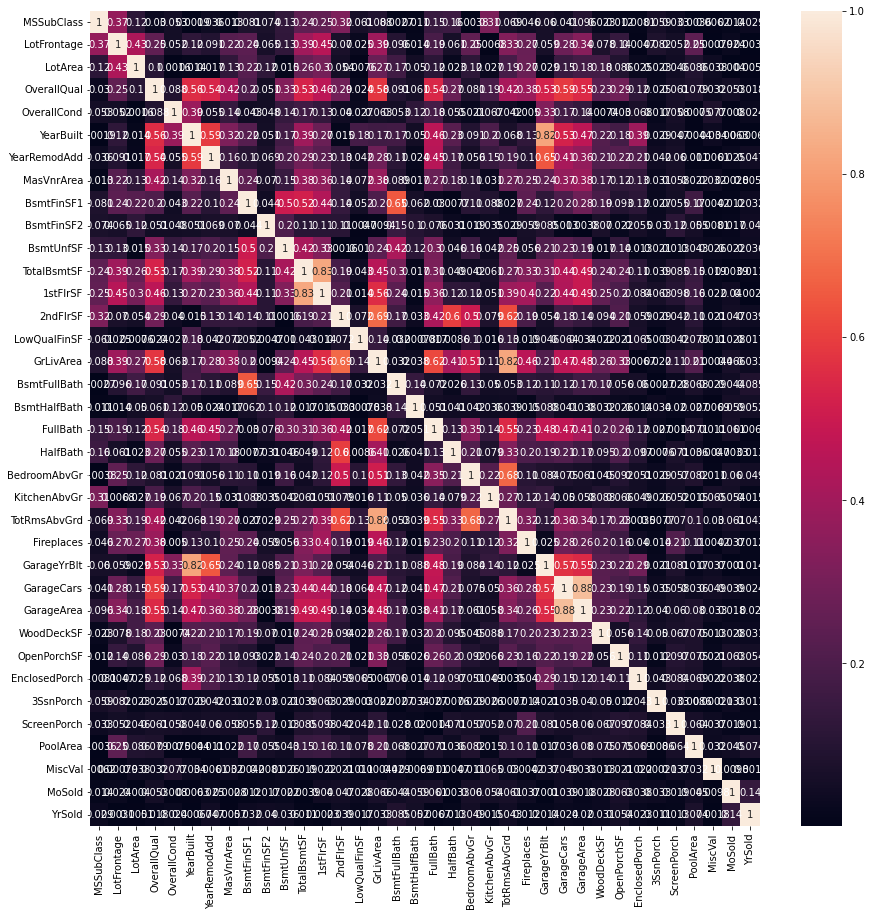

In [ ]:
# Create the correlation matrix, using the absolute values.
# For our purpose, it doesn't matter whether the correlation is positive or negative.
corrMatrix = X_train.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrMatrix, annot=True);

##***KBest***

In [ ]:
KBest = SelectKBest(score_func=f_regression)

###***Ridge***

In [ ]:
from sklearn.linear_model import Ridge


Ridge_pipeline_KB = make_pipeline(full_preprocessing, 
                             scaler,
                             KBest,
                             Ridge())

param_grid = {
    "selectkbest__k": range(10,80,5),
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "ridge__alpha": range(1,30,3)
}

Ridge_search_KB = RandomizedSearchCV(Ridge_pipeline_KB,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

Ridge_search_KB.fit(X_train, y_train)

scores.loc['Ridge', 'MAE_KBest'] = Ridge_search_KB.best_score_

In [ ]:
Ridge_predictions_KB = Ridge_search_KB.predict(X_test)
scores.loc['Ridge', 'RMSE_KBest'] = mean_squared_error(y_true = y_test, y_pred = Ridge_predictions_KB, squared=False)
scores.loc['Ridge', 'MAPE_KBest'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Ridge_predictions_KB)
scores.loc['Ridge', 'R2_KBest'] = r2_score(y_true = y_test, y_pred = Ridge_predictions_KB)

###***NearestNeighbors***

In [ ]:
KNR_pipeline_KB = make_pipeline(full_preprocessing, 
                             scaler,
                             KBest,
                             KNeighborsRegressor())

param_grid = {
    "selectkbest__k": range(10,80,5),
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    #"kneighborsregressor__n_neighbors": range(1,1000,100),

}

KNR_search_KB = RandomizedSearchCV(KNR_pipeline_KB,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

KNR_search_KB.fit(X_train, y_train)

scores.loc['KNregression', 'MAE_KBest'] = KNR_search_KB.best_score_

In [ ]:
KNR_predictions_KB = KNR_search_KB.predict(X_test)

scores.loc['KNregression', 'RMSE_KBest'] = mean_squared_error(y_true = y_test, y_pred = KNR_predictions_KB, squared=False)
scores.loc['KNregression', 'MAPE_KBest'] = mean_absolute_percentage_error(y_true = y_test, y_pred = KNR_predictions_KB)
scores.loc['KNregression', 'R2_KBest'] = r2_score(y_true = y_test, y_pred = KNR_predictions_KB)


###***Poisson***

In [ ]:
Poisson_pipeline_KB = make_pipeline(full_preprocessing,
                                     scaler, 
                                     KBest,
                                     linear_model.PoissonRegressor())

param_grid = {
    "selectkbest__k": range(10,80,5),
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "poissonregressor__max_iter": range(10,1000,10),
    "poissonregressor__alpha": range(1,30,3)

}

Poisson_search_KB = RandomizedSearchCV(Poisson_pipeline_KB,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100
                      )

Poisson_search_KB.fit(X_train, y_train)

scores.loc['PoissonRegression', 'MAE_KBest'] = Poisson_search_KB.best_score_

In [ ]:
Poisson_predictions_KB = Poisson_search_KB.predict(X_test)

scores.loc['PoissonRegression', 'RMSE_KBest'] = mean_squared_error(y_true = y_test, y_pred = Poisson_predictions_KB, squared=False)
scores.loc['PoissonRegression', 'MAPE_KBest'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Poisson_predictions_KB)
scores.loc['PoissonRegression', 'R2_KBest'] = r2_score(y_true = y_test, y_pred = Poisson_predictions_KB)


###***LinearRegression***

In [ ]:
Linear_KB = make_pipeline(full_preprocessing,
                                     scaler, 
                                     KBest,
                                     linear_model.PoissonRegressor())

param_grid = {
    "selectkbest__k": range(10,80,5),
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False]

}

Linear_search_KB = RandomizedSearchCV(Linear_KB,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100
                      )

Linear_search_KB.fit(X_train, y_train)

scores.loc['LinearRegression', 'MAE_KBest'] = Linear_search_KB.best_score_

In [ ]:
Linear_KB_predictions = Linear_search_KB.predict(X_test)

scores.loc['LinearRegression', 'RMSE_KBest'] = mean_squared_error(y_true = y_test, y_pred = Linear_KB_predictions, squared=False)
scores.loc['LinearRegression', 'MAPE_KBest'] = mean_absolute_percentage_error(y_true = y_test, y_pred = Linear_KB_predictions)
scores.loc['LinearRegression', 'R2_KBest'] = r2_score(y_true = y_test, y_pred = Linear_KB_predictions)


###***DecisionTree***

In [ ]:
DT_pipeline_KB = make_pipeline(full_preprocessing, 
                             scaler,
                             KBest,
                             DecisionTreeRegressor())

param_grid = {
    "selectkbest__k": range(10,80,5),
    "columntransformer__num_pipe__simpleimputer__strategy":["mean","constant"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "decisiontreeregressor__max_depth": range(3,15,3),
    "decisiontreeregressor__min_samples_split" : range(50,200,30)
}

DT_search_KB = RandomizedSearchCV(DT_pipeline_KB,
                      param_grid,
                      cv=10,
                      scoring="neg_mean_absolute_error",
                      verbose=1, 
                      n_iter=100)

DT_search_KB.fit(X_train, y_train)

scores.loc['DecisionTree', 'MAE_KBest'] = Poisson_search_KB.best_score_

In [ ]:
DT_predictions_KB = DT_search_KB.predict(X_test)

scores.loc['DecisionTree', 'RMSE_KBest'] = mean_squared_error(y_true = y_test, y_pred = DT_predictions_KB, squared=False)
scores.loc['DecisionTree', 'MAPE_KBest'] = mean_absolute_percentage_error(y_true = y_test, y_pred = DT_predictions_KB)
scores.loc['DecisionTree', 'R2_KBest'] = r2_score(y_true = y_test, y_pred = DT_predictions_KB)


# ***Analysis***

##***Scores***

In [ ]:
scores = scores.T.round(2)

In [ ]:
scores


,Ridge,KNregression,PoissonRegression,LinearRegression,DecisionTree
MAE,-18786.33,-29707.04,-16717.72,-20035.86,-25886.11
RMSE,31619.32,51421.28,22212.99,30780.48,42273.25
MAPE,0.11,0.19,0.09,0.12,0.15
R2,0.87,0.66,0.94,0.88,0.77
MAE_var,-18786.33,-25886.11,-16648.34,-20035.86,-25910.45
RMSE_var,31619.32,51421.28,22305.08,30780.48,41642.93
MAPE_var,0.11,0.19,0.09,0.12,0.15
R2_var,0.87,0.66,0.94,0.88,0.77
MAE_KB,-20601.05,NaN,NaN,NaN,NaN
RMSE_KB,33374.80,NaN,NaN,NaN,NaN


## ***Best parameters***

In [ ]:
Ridge_NOFS = Ridge_search.best_params_
Ridge_VAR = Ridge_search_var.best_params_
Ridge_KB = Ridge_search_KB.best_params_

In [ ]:
NNR_NOFS = KNR_search.best_params_
NNR_VAR = KNR_search_var.best_params_
NNR_KB = KNR_search_KB.best_params_

In [ ]:
Poisson_NOFS = Poisson_search.best_params_
Poisson_VAR = Poisson_search_var.best_params_
Poisson_KB = Poisson_search_KB.best_params_

In [ ]:
Linear_NOFS = LinearRegression_search.best_params_
Linear_VAR = LinearRegression_search_var.best_params_
Linear_KB = Linear_search_KB.best_params_

In [ ]:
DT_NOFS = DT_search.best_params_
DT_VAR = DT_search_var.best_params_
DT_KB = DT_search_KB.best_params_

In [ ]:
parameters_df=pd.DataFrame(data=[Ridge_NOFS,NNR_NOFS,Poisson_NOFS, Linear_NOFS,DT_NOFS,
                                 Ridge_VAR,NNR_VAR,Poisson_VAR,Linear_VAR,DT_VAR,
                                 Ridge_KB, NNR_KB,Poisson_KB, Linear_KB,DT_KB], 
        index=['Ridge_NOFS', 'NearestNeighbors_NOFS', 'PoissonRegression_NOFS', 'LinearRegression_NOFS', 'DecisionTree_NOFS',
               'Ridge_VAR', 'NearestNeighbors_VAR', 'PoissonRegression_VAR', 'LinearRegression_VAR', 'DecisionTree_VAR',
            'Ridge_KB', 'NearestNeighbors_KB', 'PoissonRegression_KB', 'LinearRegression_KB', 'DecisionTree_KB'])

In [ ]:
parameters_df.columns

Index(['standardscaler__with_std', 'standardscaler__with_mean', 'ridge__alpha',
       'columntransformer__num_pipe__simpleimputer__strategy',
       'kneighborsregressor__n_neighbors', 'poissonregressor__max_iter',
       'poissonregressor__alpha', 'decisiontreeregressor__min_samples_split',
       'decisiontreeregressor__max_depth', 'selectkbest__k'],
      dtype='object')

In [ ]:
fix_param_df = parameters_df[['standardscaler__with_std', 'standardscaler__with_mean','columntransformer__num_pipe__simpleimputer__strategy','selectkbest__k']]
fix_param_df = fix_param_df.rename(columns=({'standardscaler__with_std':'S_scaler_std'
, 'standardscaler__with_mean': 'S_scaler_mean'
,'columntransformer__num_pipe__simpleimputer__strategy': 'Num_Imputer_Strategy'
,'selectkbest__k':'FeatureKBest'}))
fix_param_df

,S_scaler_std,S_scaler_mean,Num_Imputer_Strategy,FeatureKBest
Ridge_NOFS,False,True,constant,NaN
NearestNeighbors_NOFS,True,False,mean,NaN
PoissonRegression_NOFS,True,False,constant,NaN
LinearRegression_NOFS,False,False,constant,NaN
DecisionTree_NOFS,True,True,mean,NaN
Ridge_VAR,False,False,constant,NaN
NearestNeighbors_VAR,True,True,mean,NaN
PoissonRegression_VAR,True,False,constant,NaN
LinearRegression_VAR,False,False,constant,NaN
DecisionTree_VAR,True,False,constant,NaN


#***LAZYPREDICT***

In [ ]:
!pip install lazypredict


# ***LazyPredict***

In [ ]:
from lazypredict.Supervised import LazyRegressor


In [ ]:
url = "https://drive.google.com/file/d/1t3Rxpb5Hr0baI1KZWSvrAujv68A_CdnK/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

In [ ]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# X and y creation
X = data.select_dtypes(include="number").copy()
X.pop('Id')
y = X.pop("SalePrice")
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 93%|█████████▎| 39/42 [01:02<00:06,  2.20s/it]

[10:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 42/42 [01:03<00:00,  1.52s/it]


In [ ]:
models.sort_values(by='RMSE')

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.88,0.90,27850.45,0.58
ExtraTreesRegressor,0.88,0.90,28256.18,0.87
HistGradientBoostingRegressor,0.87,0.89,28997.34,0.61
RandomForestRegressor,0.87,0.89,29520.14,1.43
PoissonRegressor,0.86,0.88,30815.95,0.05
LGBMRegressor,0.86,0.88,30884.10,0.33
XGBRegressor,0.86,0.88,30907.85,0.25
BaggingRegressor,0.84,0.86,32530.90,0.16
GammaRegressor,0.83,0.85,33820.76,0.03
